# Model analysis

In [1]:
import project_path  # Always import this first

In [2]:
from datetime import datetime
from pathlib import Path

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from torch.utils.data import DataLoader

from utils.concrete import ConcreteSelect, decoder_1l, decoder_2l, decoder_3l
from utils.dataset import MRISelectorSubjDataset
from utils.env import DATA_PATH
from utils.logger import logger

In [3]:
sns.set_theme(
    context="notebook", style="ticks", rc={"figure.figsize": (11.7 / 2, 8.27 / 2)}
)

In [4]:
ROOT_PATH = Path().cwd().parent
logger.debug(ROOT_PATH)

2021-07-07 16:12:48,797 - geometric-dl - DEBUG - C:\Users\user\Workspace\geometric-dl-dmri (<ipython-input-4-6bfbdaf6256e>:2)


In [5]:
logger.info("torch version %s", torch.__version__)

2021-07-07 16:12:48,828 - geometric-dl - INFO - torch version 1.9.0 (<ipython-input-5-3c2fef3d866b>:1)


In [6]:
# use gpu if available, else cpu
has_cuda = torch.cuda.is_available()

logger.info("Is the GPU available? %s", has_cuda)
logger.info("Current device: %s", torch.cuda.current_device())
logger.info("Device count: %s", torch.cuda.device_count())

device = torch.device("cuda" if has_cuda else "cpu")
if has_cuda:
    torch.cuda.set_device(0)
    logger.info("Using device: %s", torch.cuda.get_device_properties(device))
else:
    logger.warning("No GPU dectected! Training will be extremly slow")

2021-07-07 16:12:48,969 - geometric-dl - INFO - Is the GPU available? True (<ipython-input-6-0077c854e8eb>:4)
2021-07-07 16:12:48,969 - geometric-dl - INFO - Current device: 0 (<ipython-input-6-0077c854e8eb>:5)
2021-07-07 16:12:48,969 - geometric-dl - INFO - Device count: 1 (<ipython-input-6-0077c854e8eb>:6)
2021-07-07 16:12:48,984 - geometric-dl - INFO - Using device: _CudaDeviceProperties(name='Quadro RTX 4000', major=7, minor=5, total_memory=8192MB, multi_processor_count=36) (<ipython-input-6-0077c854e8eb>:11)


## Loading the models

First we need to cleanup the filename string. For this we define some helper functions. The string does not really have a nice structure so the cleanup functions are a bit messy.

In [7]:
def extract_features(feature_str):
    """Create a Dict with all the features from the model, extracted from its file name"""
    strdate = feature_str[:14]
    features_dict = to_dict(
        [split_str(substr) for substr in feature_str[15:].split("=")]
    )
    features_dict["datetime"] = datetime.strptime(strdate, "%Y%m%d%H%M%S")

    return features_dict


def split_str(s):
    if s.startswith("decoder"):
        # name of the decoder function string contains a '_' character so it needs special treatment
        split = s.split("_", 2)
        return ["_".join(split[:2]), split[-1]]
    return s.split("_", 1)


def to_dict(fs):
    return dict([fs[i][-1], l[0]] for i, l in enumerate(fs[1:]))

Create lookup Dict to map decoder name to decoder function

In [8]:
decoder_dict = dict(
    [decoder.__name__, decoder] for decoder in [decoder_1l, decoder_2l, decoder_3l]
)

Load the models and store them in a pandas dataframe

In [9]:
models_path = Path(ROOT_PATH, "runs", "models")

frames = []
for model_path in models_path.glob("*.pt"):
    stem = model_path.stem  # get the file name without the suffix

    logger.debug("found: %s", stem)

    features_dict = extract_features(stem)

    features_path = model_path.name.replace("_params.pt", ".txt")
    features_path = model_path.with_name(features_path)

    features_dict["params_path"] = model_path
    features_dict["features_path"] = features_path

    # Convert types
    features_dict["lr"] = float(features_dict["lr"])
    features_dict["batch_size"] = int(features_dict["batch_size"])
    features_dict["num_epochs"] = int(features_dict["num_epochs"])
    features_dict["n_features"] = int(features_dict["n_features"])
    features_dict["test"] = int(features_dict["test"])

    if "exclude" in features_dict:
        features_dict["exclude"] = np.array(
            features_dict["exclude"].split("-"), dtype=np.uint16
        )
    else:
        features_dict["exclude"] = []

    df_part = pd.DataFrame.from_records([features_dict], index="datetime")
    frames.append(df_part)
#     break

df = pd.concat(frames)
df

2021-07-07 16:12:55,671 - geometric-dl - DEBUG - found: 20210628104435_lr=0.001_batch_size=256_num_epochs=2000_n_features=21_decoder=decoder_1l_test=15_params (<ipython-input-9-8b2a083985e0>:7)
2021-07-07 16:12:55,671 - geometric-dl - DEBUG - found: 20210628144827_lr=0.001_batch_size=256_num_epochs=2000_n_features=21_decoder=decoder_2l_test=15_params (<ipython-input-9-8b2a083985e0>:7)
2021-07-07 16:12:55,671 - geometric-dl - DEBUG - found: 20210628193111_lr=0.001_batch_size=256_num_epochs=2000_n_features=21_decoder=decoder_3l_test=15_params (<ipython-input-9-8b2a083985e0>:7)
2021-07-07 16:12:55,687 - geometric-dl - DEBUG - found: 20210629004725_lr=0.001_batch_size=256_num_epochs=2000_n_features=42_decoder=decoder_1l_test=15_params (<ipython-input-9-8b2a083985e0>:7)
2021-07-07 16:12:55,687 - geometric-dl - DEBUG - found: 20210629044553_lr=0.001_batch_size=256_num_epochs=2000_n_features=42_decoder=decoder_2l_test=15_params (<ipython-input-9-8b2a083985e0>:7)
2021-07-07 16:12:55,687 - geom

,lr,batch_size,num_epochs,n_features,decoder,test,params_path,features_path,exclude
datetime,,,,,,,,,
2021-06-28 10:44:35,0.001,256,2000,21,decoder_1l,15,C:\Users\user\Workspace\geometric-dl-dmri\runs...,C:\Users\user\Workspace\geometric-dl-dmri\runs...,[]
2021-06-28 14:48:27,0.001,256,2000,21,decoder_2l,15,C:\Users\user\Workspace\geometric-dl-dmri\runs...,C:\Users\user\Workspace\geometric-dl-dmri\runs...,[]
2021-06-28 19:31:11,0.001,256,2000,21,decoder_3l,15,C:\Users\user\Workspace\geometric-dl-dmri\runs...,C:\Users\user\Workspace\geometric-dl-dmri\runs...,[]
2021-06-29 00:47:25,0.001,256,2000,42,decoder_1l,15,C:\Users\user\Workspace\geometric-dl-dmri\runs...,C:\Users\user\Workspace\geometric-dl-dmri\runs...,[]
2021-06-29 04:45:53,0.001,256,2000,42,decoder_2l,15,C:\Users\user\Workspace\geometric-dl-dmri\runs...,C:\Users\user\Workspace\geometric-dl-dmri\runs...,[]
2021-06-29 09:33:59,0.001,256,2000,42,decoder_3l,15,C:\Users\user\Workspace\geometric-dl-dmri\runs...,C:\Users\user\Workspace\geometric-dl-dmri\runs...,[]
2021-06-29 14:51:26,0.001,256,2000,84,decoder_1l,15,C:\Users\user\Workspace\geometric-dl-dmri\runs...,C:\Users\user\Workspace\geometric-dl-dmri\runs...,[]
2021-06-29 18:54:22,0.001,256,2000,84,decoder_2l,15,C:\Users\user\Workspace\geometric-dl-dmri\runs...,C:\Users\user\Workspace\geometric-dl-dmri\runs...,[]
2021-06-29 23:41:58,0.001,256,2000,84,decoder_3l,15,C:\Users\user\Workspace\geometric-dl-dmri\runs...,C:\Users\user\Workspace\geometric-dl-dmri\runs...,[]


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 17 entries, 2021-06-28 10:44:35 to 2021-07-03 01:54:12
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   lr             17 non-null     float64
 1   batch_size     17 non-null     int64  
 2   num_epochs     17 non-null     int64  
 3   n_features     17 non-null     int64  
 4   decoder        17 non-null     object 
 5   test           17 non-null     int64  
 6   params_path    17 non-null     object 
 7   features_path  17 non-null     object 
 8   exclude        17 non-null     object 
dtypes: float64(1), int64(4), object(4)
memory usage: 1.3+ KB


## Model evalutation

In [11]:
IMAGES_PATH = Path(ROOT_PATH, "images")
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

In [12]:
test_set = MRISelectorSubjDataset(
    Path(ROOT_PATH, "data"), "data_.hdf5", "header_.csv", np.array([15])
)
test_gen = DataLoader(
    test_set,
    batch_size=256,
    shuffle=False,
    num_workers=0,
    pin_memory=True,
    drop_last=True,
)

### Reconstruction loss (MSE) for each model

In [41]:
mse_loss = torch.nn.MSELoss().to(device)


def calc_loss(row):
    model_path = row["params_path"]
    model = ConcreteSelect(
        output_dim=int(row["n_features"]),
        input_shape=1344 - len(row["exclude"]),
        decoder=decoder_dict[row["decoder"]],
        device=device,
    ).to(device)
    model.load_state_dict(torch.load(model_path))
    model.eval()
    with torch.no_grad():
        x = np.delete(test_set[10], row["exclude"])
        target = torch.from_numpy(x).to(device)
        pred, _ = model(target)
        loss = mse_loss(pred, target).to("cpu")

    logger.info(
        "decoder: %s - latent space: %s - loss: %s",
        row["decoder"],
        row["n_features"],
        loss.item(),
    )

    return loss.item()


df["loss"] = df.apply(calc_loss, axis=1)

0.008377668
2021-07-07 18:45:40,499 - geometric-dl - INFO - decoder: decoder_1l - latent space: 21 - loss: 156.3868408203125 (<ipython-input-41-d1a3284d974c>:22)
0.008377668
2021-07-07 18:45:40,499 - geometric-dl - INFO - decoder: decoder_2l - latent space: 21 - loss: 11.718282699584961 (<ipython-input-41-d1a3284d974c>:22)
0.008377668
2021-07-07 18:45:40,499 - geometric-dl - INFO - decoder: decoder_3l - latent space: 21 - loss: 2.1746151447296143 (<ipython-input-41-d1a3284d974c>:22)
0.008377668
2021-07-07 18:45:40,515 - geometric-dl - INFO - decoder: decoder_1l - latent space: 42 - loss: 98.48184204101562 (<ipython-input-41-d1a3284d974c>:22)
0.008377668
2021-07-07 18:45:40,515 - geometric-dl - INFO - decoder: decoder_2l - latent space: 42 - loss: 14.703828811645508 (<ipython-input-41-d1a3284d974c>:22)
0.008377668
2021-07-07 18:45:40,521 - geometric-dl - INFO - decoder: decoder_3l - latent space: 42 - loss: 1.998077392578125 (<ipython-input-41-d1a3284d974c>:22)
0.008377668
2021-07-07 18

In [14]:
df.replace(np.inf, np.nan, inplace=True)
df.sort_index()

,lr,batch_size,num_epochs,n_features,decoder,test,params_path,features_path,exclude,loss
datetime,,,,,,,,,,
2021-06-28 10:44:35,0.001,256,2000,21,decoder_1l,15,C:\Users\user\Workspace\geometric-dl-dmri\runs...,C:\Users\user\Workspace\geometric-dl-dmri\runs...,[],164.534256
2021-06-28 14:48:27,0.001,256,2000,21,decoder_2l,15,C:\Users\user\Workspace\geometric-dl-dmri\runs...,C:\Users\user\Workspace\geometric-dl-dmri\runs...,[],11.872165
2021-06-28 19:31:11,0.001,256,2000,21,decoder_3l,15,C:\Users\user\Workspace\geometric-dl-dmri\runs...,C:\Users\user\Workspace\geometric-dl-dmri\runs...,[],2.036448
2021-06-29 00:47:25,0.001,256,2000,42,decoder_1l,15,C:\Users\user\Workspace\geometric-dl-dmri\runs...,C:\Users\user\Workspace\geometric-dl-dmri\runs...,[],90.669205
2021-06-29 04:45:53,0.001,256,2000,42,decoder_2l,15,C:\Users\user\Workspace\geometric-dl-dmri\runs...,C:\Users\user\Workspace\geometric-dl-dmri\runs...,[],13.355157
2021-06-29 09:33:59,0.001,256,2000,42,decoder_3l,15,C:\Users\user\Workspace\geometric-dl-dmri\runs...,C:\Users\user\Workspace\geometric-dl-dmri\runs...,[],1.732313
2021-06-29 14:51:26,0.001,256,2000,84,decoder_1l,15,C:\Users\user\Workspace\geometric-dl-dmri\runs...,C:\Users\user\Workspace\geometric-dl-dmri\runs...,[],99.435936
2021-06-29 18:54:22,0.001,256,2000,84,decoder_2l,15,C:\Users\user\Workspace\geometric-dl-dmri\runs...,C:\Users\user\Workspace\geometric-dl-dmri\runs...,[],12.638646
2021-06-29 23:41:58,0.001,256,2000,84,decoder_3l,15,C:\Users\user\Workspace\geometric-dl-dmri\runs...,C:\Users\user\Workspace\geometric-dl-dmri\runs...,[],0.585410


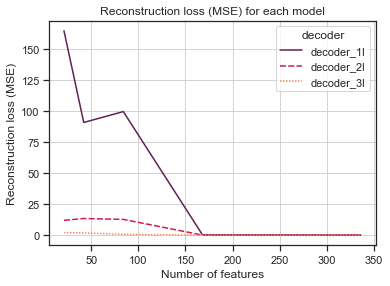

In [15]:
plot = sns.lineplot(
    x="n_features",
    y="loss",
    hue="decoder",
    style="decoder",
    data=df.iloc[:-2],
    palette="rocket",
)
# plot.set(yscale='log')
plot.set(
    xlabel="Number of features",
    ylabel="Reconstruction loss (MSE)",
    title="Reconstruction loss (MSE) for each model",
)
plt.grid(True, which="both", ls="-", c="lightgray")

image_path = Path(IMAGES_PATH, "reconstruction_loss_(MSE).pdf")
plt.savefig(image_path);

### Plot feature occurence count

Some features occure multiple times in a single model. Lets plot the top 20 most occuring features.

In [49]:
def get_feat_count(row):
    features = np.loadtxt(row["features_path"], dtype=np.int64)
    counts = np.bincount(features)
    counts_df = pd.DataFrame(counts, columns=["count"])
    return counts_df


def get_feat_counts(data):
    counts_dfs = []
    if type(data) is pd.DataFrame:
        for _, row in data.iterrows():
            counts_df = get_feat_count(row)
            counts_dfs.append(counts_df)
    else:  # assume it is a Series
        counts_df = get_feat_count(data)
        counts_dfs.append(counts_df)
    # sum all the bin counts
    df_counts = pd.concat(counts_dfs).groupby(level=0).sum().reset_index()
    return df_counts


df_counts_total = get_feat_counts(df.iloc[:-2])
df_counts_1 = get_feat_counts(df.iloc[-3])
df_counts_exclude_1 = get_feat_counts(df.iloc[-2])
df_counts_exclude_2 = get_feat_counts(df.iloc[-1])
df_counts_2 = get_feat_counts(df.iloc[-5])
df_counts_3 = get_feat_counts(df.iloc[-4])

In [23]:
def show_values_on_bars(axs, h_v="v", space=0.4):
    """Code from https://stackoverflow.com/a/56780852/6131485"""

    def _show_on_single_plot(ax):
        if h_v == "v":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() / 2
                _y = p.get_y() + p.get_height()
                value = int(p.get_height())
                ax.text(_x, _y, value, ha="center")
        elif h_v == "h":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() - float(space)
                _y = p.get_y() + p.get_height() - 0.2
                value = int(p.get_width())
                ax.text(_x, _y, value, ha="right", c="white")

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)

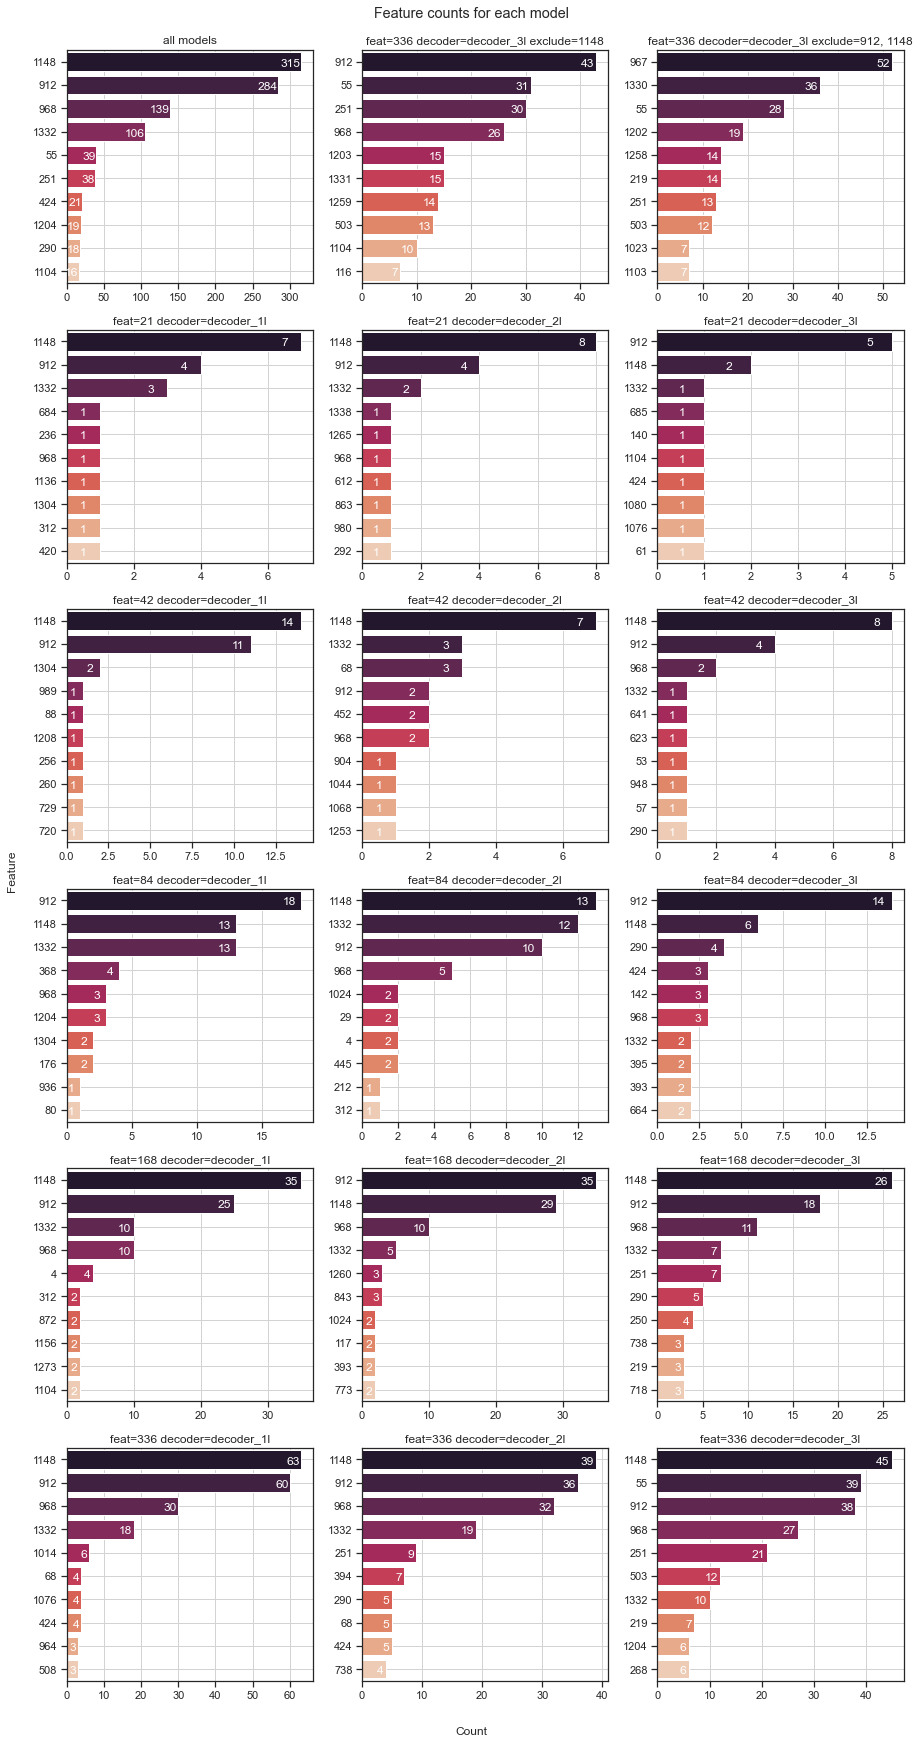

In [91]:
def plot_counts(df, top_size=10, ax=None, title=None):
    df_counts = df.sort_values(by="count", ascending=False)[:top_size]
    plot = sns.barplot(
        orient="h",
        x="count",
        y="index",
        data=df_counts,
        order=df_counts["index"].values,
        palette="rocket",
        ax=ax,
    )
    plot.set(xlabel=None, ylabel=None, title=title)
    show_values_on_bars(plot, "h")
    if ax is not None:
        ax.grid(True, which="both", ls="-", c="lightgray")


fig, axes = plt.subplots(6, 3, figsize=(5 * 3, 5 * 6))
fig.suptitle("Feature counts for each model", x=0.5, y=0.9)
fig.text(0.5, 0.1, "Count", ha="center")
fig.text(0.07, 0.5, "Feature", va="center", rotation="vertical")

plot_counts(df_counts_total, ax=axes[0, 0], title="all models")
plot_counts(
    df_counts_exclude_1,
    ax=axes[0, 1],
    title="feat=336 decoder=decoder_3l exclude=1148",
)
plot_counts(
    df_counts_exclude_2,
    ax=axes[0, 2],
    title="feat=336 decoder=decoder_3l exclude=912, 1148",
)

for i, ax in enumerate(axes[1:].flatten()):
    row = df.iloc[i]
    df_counts = get_feat_counts(row)
    plot_counts(
        df_counts, ax=ax, title=f"feat={row['n_features']} decoder={row['decoder']}"
    )

image_path = Path(IMAGES_PATH, "feature_count.pdf")
plt.savefig(image_path);